In [1]:
import pandas as pd
import numpy as np
from numpy import mean

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import (
    accuracy_score,
    f1_score, roc_auc_score, make_scorer
)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from collections import Counter

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

RANDOM_STATE = 4

In [2]:
# Importing the dataset, creating the dataframe and exploring it
df = pd.read_csv('data/diabetes_processed.csv')
df

,Glucose,Medical_Risk,DiabetesPedigreeFunction,BMI,Diabetes_Risk,BMI_to_BloodPressure_Ratio,Pregnancies,Outcome
0,148,120.9600,0.627,33.6,1.929187,0.466667,6,1
1,85,54.4236,0.351,26.6,1.550530,0.403030,1,0
2,183,47.7184,0.672,23.3,0.710095,0.364063,8,1
3,89,38.9466,0.167,28.1,2.332132,0.425758,1,0
4,116,56.8320,0.201,25.6,2.827463,0.345946,5,0
...,...,...,...,...,...,...,...,...
684,101,157.5252,0.171,32.9,9.212000,0.432895,10,0
685,122,69.5520,0.340,36.8,2.045647,0.525714,2,0
686,121,56.5920,0.245,26.2,2.309878,0.363889,5,0
687,126,84.8820,0.349,30.1,2.432149,0.501667,1,1


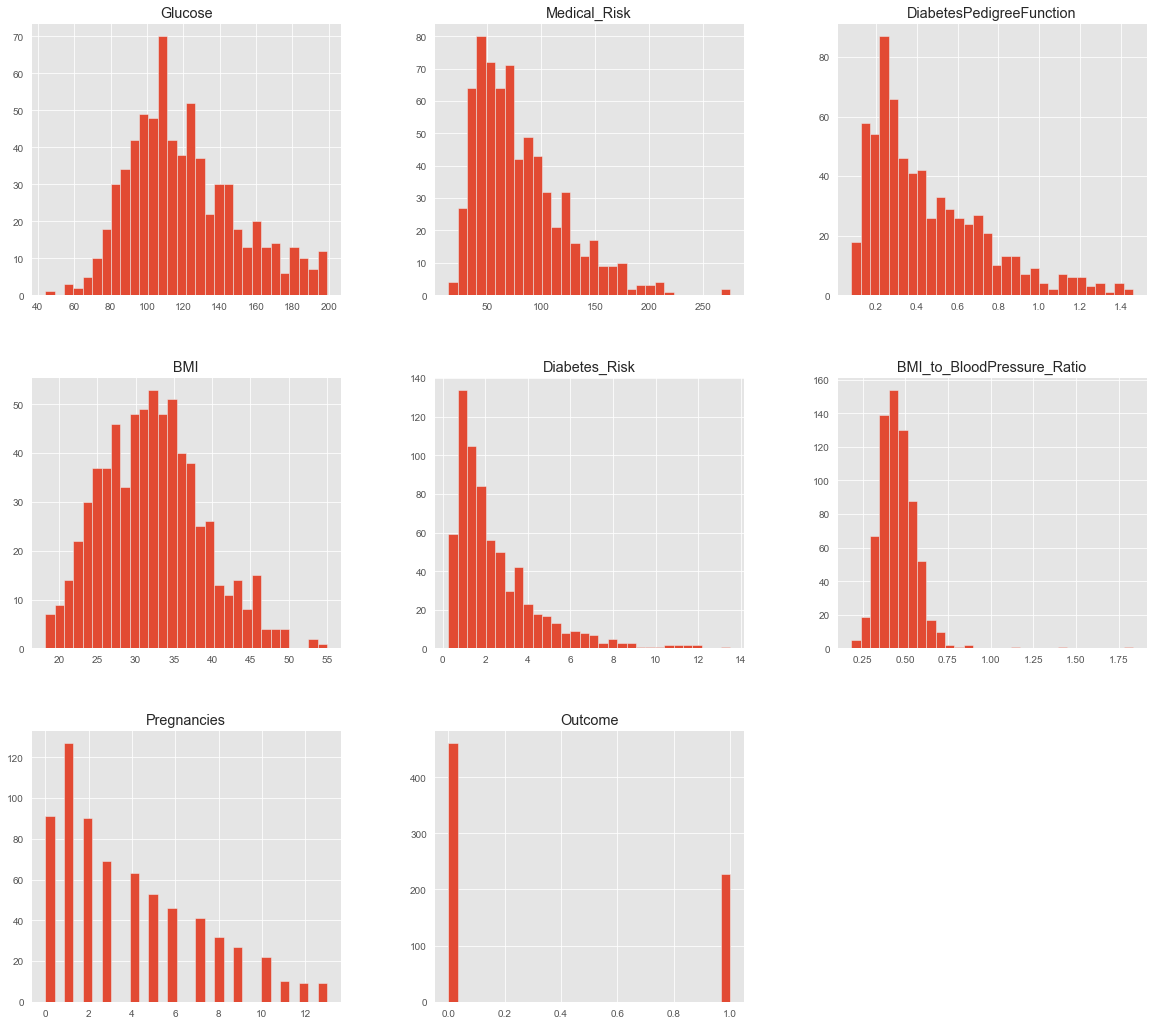

In [3]:
# Visualizing data distribution for each feature
df.hist(bins=30, figsize=(20, 18))
plt.show()

# Defining functions for later use

In [4]:
# Plot Confusion Matrix and include accuracy and F1 score
def plot_confusion_matrix(y_test, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    mat = confusion_matrix(y_pred, y_test)
    names = np.unique(y_pred)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=names, yticklabels=names)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average="weighted")

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

In [5]:
def show_cross_val_scores(model, X, Y):
    k_fold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, Y, cv=k_fold, n_jobs=1)
    for i in range(len(scores)):
        score = '%.3f'%(scores[i]*100)
        print("Fold {i} Accuracy: {score}%".format(i=i+1, score=score))
        
    print("Average Accuracy: {score}%".format(score=scores.mean()*100))

## Splitting Train-Test Data

In [6]:
#first we split the data into features and label
Y = df['Outcome'] #label
X = df.drop('Outcome', axis=1) #features
# Then we need to split data set into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE, shuffle=True)

# Check the number of records after over sampling
print(sorted(Counter(y_train).items()))

[(0, 316), (1, 166)]


## Under-sampling to balance the Data

In [7]:
# from imblearn.under_sampling import NearMiss
#
# # Under sample the majority class
# nearmiss = NearMiss(version=3)
# x_train, y_train= nearmiss.fit_resample(x_train, y_train)
# # Check the number of records after over sampling
# print(sorted(Counter(y_train).items()))

## Over-sampling to balance the Data

In [8]:
# from imblearn.over_sampling import SMOTE
#
# # Randomly over sample the minority class
# smote = SMOTE(random_state=42)
# x_train, y_train= smote.fit_resample(x_train, y_train)
# # Check the number of records after over sampling
# print(sorted(Counter(y_train).items()))

# Following paper methodologies
## Classifiers used: 
1. Naive Bayes (Presented in paper)
2. Decision tree (Presented in paper)
3. Random Forest
4. Logistic Regression
5. SVM
6. KNN

## Training methods:
1. Using a 70:30 train test split 
2. 10-fold cross validation

## Hyperparameter Tuning

In [9]:
# Define the parameter grid for each classifier with more options
nb_param_grid = {'var_smoothing': [1e-12, 1e-10, 1e-8, 1e-6, 1e-4]}
dt_param_grid = {'max_depth': [5, 10, 15, 20, 25], 'min_samples_split': [2, 5, 10]}
rf_param_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 5, 10]}
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
svm_param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4]}
knn_param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Define the classifiers to use
nb = GaussianNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
svm = SVC()
knn = KNeighborsClassifier()

# Define the hyperparameter tuning using GridSearchCV for each classifier
nb_grid = GridSearchCV(nb, nb_param_grid, cv=5, scoring=make_scorer(f1_score))
dt_grid = GridSearchCV(dt, dt_param_grid, cv=5, scoring=make_scorer(f1_score))
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring=make_scorer(f1_score))
lr_grid = GridSearchCV(lr, lr_param_grid, cv=5, scoring=make_scorer(f1_score))
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, scoring=make_scorer(f1_score))
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring=make_scorer(f1_score))

# Fit the hyperparameter tuning on the training data
nb_grid.fit(x_train, y_train)
dt_grid.fit(x_train, y_train)
rf_grid.fit(x_train, y_train)
lr_grid.fit(x_train, y_train)
svm_grid.fit(x_train, y_train)
knn_grid.fit(x_train, y_train)

# Print the best hyperparameters and corresponding F1 score for each classifier
print("Naive Bayes:", nb_grid.best_params_, nb_grid.best_score_)
print("Decision Tree:", dt_grid.best_params_, dt_grid.best_score_)
print("Random Forest:", rf_grid.best_params_, rf_grid.best_score_)
print("Logistic Regression:", lr_grid.best_params_, lr_grid.best_score_)
print("SVM:", svm_grid.best_params_, svm_grid.best_score_)
print("KNN:", knn_grid.best_params_, knn_grid.best_score_)

Naive Bayes: {'var_smoothing': 1e-06} 0.5952825980196196
Decision Tree: {'max_depth': 15, 'min_samples_split': 5} 0.5646896031622197
Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50} 0.576667165574776
Logistic Regression: {'C': 1, 'penalty': 'l2'} 0.6168123861566486
SVM: {'C': 10, 'degree': 2, 'kernel': 'linear'} 0.6082709557686361
KNN: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'uniform'} 0.5713469627210034


# Naive Bayes Classifier (Gaussian) results

ROC AUC score: 0.8388209121245829
Accuracy: 0.782608695652174
F1 Score: 0.7865500039413083
Fold 1 Accuracy: 69.388%
Fold 2 Accuracy: 67.347%
Fold 3 Accuracy: 79.167%
Fold 4 Accuracy: 77.083%
Fold 5 Accuracy: 77.083%
Fold 6 Accuracy: 79.167%
Fold 7 Accuracy: 77.083%
Fold 8 Accuracy: 77.083%
Fold 9 Accuracy: 64.583%
Fold 10 Accuracy: 81.250%
Average Accuracy: 74.9234693877551%


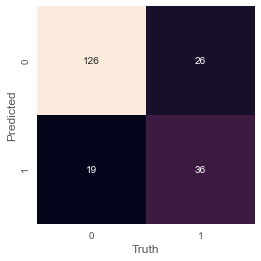

In [10]:
# Init the Gaussian Classifier (data)
gaussNB_model = GaussianNB(var_smoothing=1e-06)
# Train the model 
gaussNB_model.fit(x_train, y_train)
# Predict Output 
y_pred = gaussNB_model.predict(x_test)

y_pred_proba = gaussNB_model.predict_proba(x_test)[:, 1] # probability of positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score:', roc_auc)

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred, classes=['0', '1'], normalize=False, title='Confusion matrix')

# Using 10 Fold Cross Validation
show_cross_val_scores(gaussNB_model, x_train, y_train)

# Decision tree Classifier results

ROC AUC score: 0.7833147942157952
Accuracy: 0.7584541062801933
F1 Score: 0.8050349151998593
Fold 1 Accuracy: 71.429%
Fold 2 Accuracy: 75.510%
Fold 3 Accuracy: 77.083%
Fold 4 Accuracy: 68.750%
Fold 5 Accuracy: 85.417%
Fold 6 Accuracy: 77.083%
Fold 7 Accuracy: 75.000%
Fold 8 Accuracy: 72.917%
Fold 9 Accuracy: 60.417%
Fold 10 Accuracy: 85.417%
Average Accuracy: 74.90221088435375%


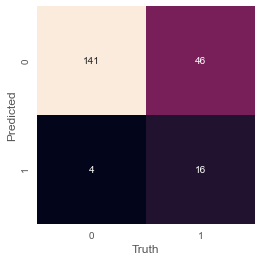

In [11]:
# Create Decision Tree classifer object
classifier_tree = DecisionTreeClassifier(criterion="entropy", splitter="best",max_depth=3)

# Train Decision Tree Classifer
classifier_tree = classifier_tree.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = classifier_tree.predict(x_test)

y_pred_proba = classifier_tree.predict_proba(x_test)[:, 1] # probability of positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score:', roc_auc)

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred, classes=['0', '1'], normalize=False, title='Confusion matrix')

# Using 10 Fold Cross Validation
show_cross_val_scores(classifier_tree, x_train, y_train)

## Visualizing the Decision Tree

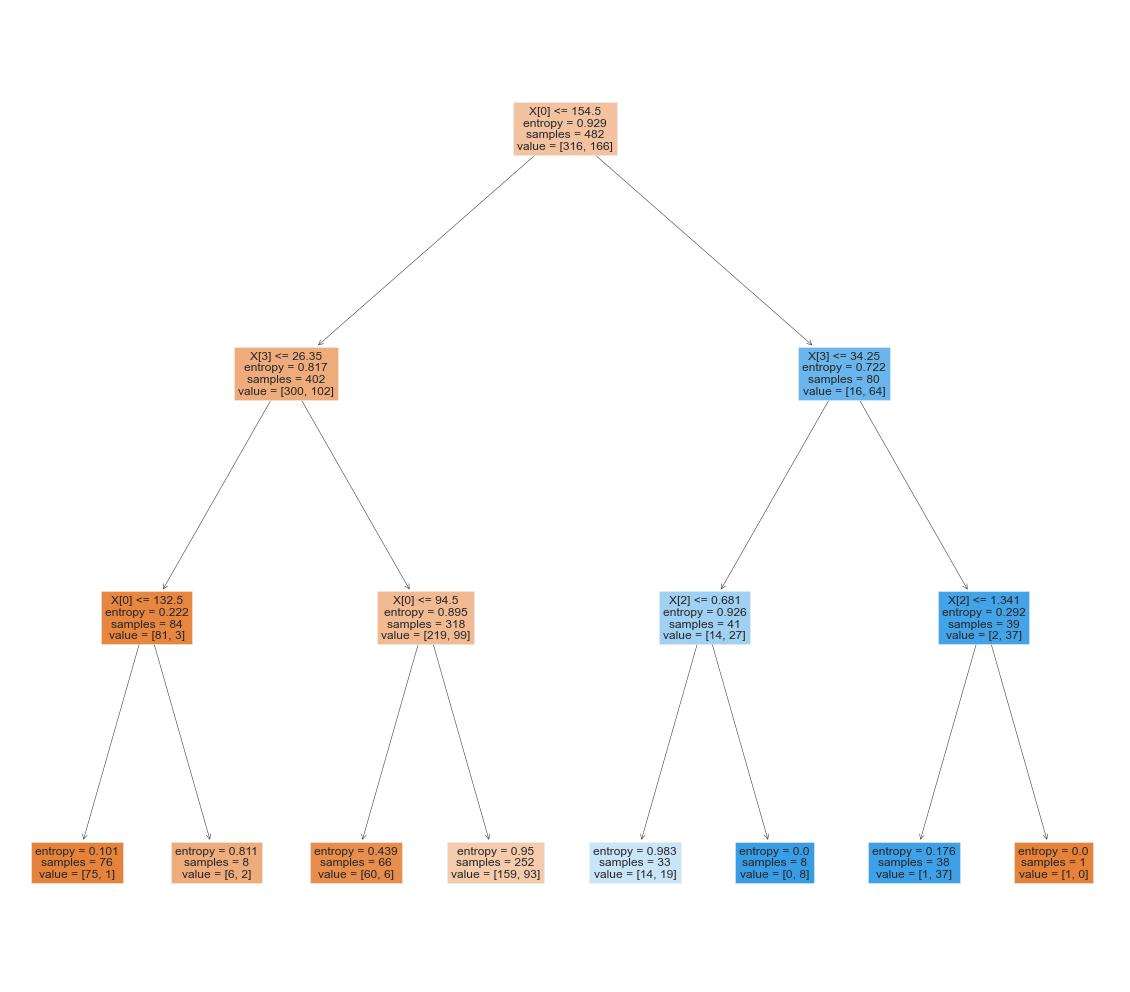

In [12]:
# Plot the decision tree using matplotlib
plt.figure(figsize=(20, 18))
tree.plot_tree(classifier_tree, filled=True, fontsize=12)
plt.savefig("assets/DecisionTree.png")

# Random Forest Classifier results

total error: 20.77294685990338
ROC AUC score: 0.8599555061179088
Accuracy: 0.7922705314009661
F1 Score: 0.8030209377030867
Fold 1 Accuracy: 69.388%
Fold 2 Accuracy: 73.469%
Fold 3 Accuracy: 75.000%
Fold 4 Accuracy: 70.833%
Fold 5 Accuracy: 85.417%
Fold 6 Accuracy: 75.000%
Fold 7 Accuracy: 75.000%
Fold 8 Accuracy: 83.333%
Fold 9 Accuracy: 60.417%
Fold 10 Accuracy: 79.167%
Average Accuracy: 74.70238095238095%


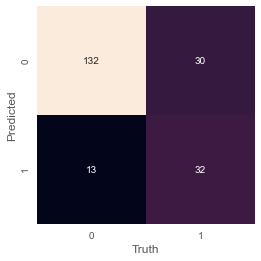

In [13]:
#create a random forest object
rf_classifier= RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_split=5)

#train the model and fit the model 
rf_classifier.fit(x_train, y_train)

#predict the model's response
RFpredictions = rf_classifier.predict(x_test)

# calculate the error for each cell, then the average absolte percentage error
errors = abs(RFpredictions - y_test)
all_error_percentage= mean(errors)*100

#print the results
print("total error:",all_error_percentage)
# print(classification_report(y_test,RFpredictions))

y_pred_proba = rf_classifier.predict_proba(x_test)[:, 1] # probability of positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score:', roc_auc)


plot_confusion_matrix(y_test, RFpredictions, classes=['0', '1'], normalize=False, title='Confusion matrix')

# Using 10 Fold Cross Validation
show_cross_val_scores(rf_classifier, x_train, y_train)

# Logistic regression Classifier results

ROC AUC score: 0.8667408231368188
Accuracy: 0.8164251207729468
F1 Score: 0.8266474661060387
Fold 1 Accuracy: 67.347%
Fold 2 Accuracy: 77.551%
Fold 3 Accuracy: 79.167%
Fold 4 Accuracy: 75.000%
Fold 5 Accuracy: 81.250%
Fold 6 Accuracy: 81.250%
Fold 7 Accuracy: 77.083%
Fold 8 Accuracy: 83.333%
Fold 9 Accuracy: 62.500%
Fold 10 Accuracy: 81.250%
Average Accuracy: 76.57312925170068%


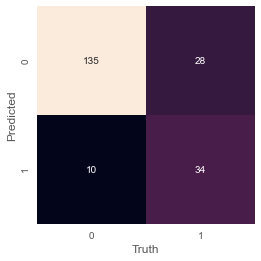

In [14]:
# Create Logistic Regression classifer object
logisticReg = LogisticRegression(C=1, penalty='l2')

# Train logistic Classifer
logisticReg.fit(x_train, y_train)

#Predict the response for test dataset
logisticRegPredictions = logisticReg.predict(x_test)

#score 
# score=logisticReg.score(x_test, y_test)
# print(score)
y_pred_proba = logisticReg.predict_proba(x_test)[:, 1] # probability of positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC score:', roc_auc)
# Plot Confusion Matrix
plot_confusion_matrix(y_test, logisticRegPredictions, classes=['0', '1'], normalize=False, title='Confusion matrix')

# Using 10 Fold Cross Validation
show_cross_val_scores(logisticReg, x_train, y_train)

# SVM Classifier Results

Accuracy: 0.8309178743961353
F1 Score: 0.8383942084204301
Fold 1 Accuracy: 71.429%
Fold 2 Accuracy: 73.469%
Fold 3 Accuracy: 79.167%
Fold 4 Accuracy: 75.000%
Fold 5 Accuracy: 81.250%
Fold 6 Accuracy: 81.250%
Fold 7 Accuracy: 79.167%
Fold 8 Accuracy: 79.167%
Fold 9 Accuracy: 66.667%
Fold 10 Accuracy: 85.417%
Average Accuracy: 77.19812925170068%


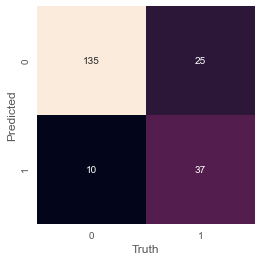

In [15]:
#initialize the svm model
svmModel = SVC(kernel='linear', degree=2, C=10)
# Train logistic Classifer
svmModel.fit(x_train, y_train)

#Predict the response for test dataset
svmPredications = svmModel.predict(x_test)

plot_confusion_matrix(y_test, svmPredications, classes=['0', '1'], normalize=False, title='Confusion matrix')

# Using 10 Fold Cross Validation
show_cross_val_scores(svmModel, x_train, y_train)

# KNN classifier results

Accuracy: 0.782608695652174
F1 Score: 0.7922211251119814
Fold 1 Accuracy: 69.388%
Fold 2 Accuracy: 79.592%
Fold 3 Accuracy: 77.083%
Fold 4 Accuracy: 70.833%
Fold 5 Accuracy: 79.167%
Fold 6 Accuracy: 77.083%
Fold 7 Accuracy: 72.917%
Fold 8 Accuracy: 72.917%
Fold 9 Accuracy: 62.500%
Fold 10 Accuracy: 70.833%
Average Accuracy: 73.23129251700679%


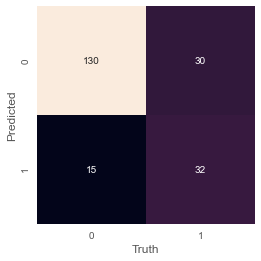

In [16]:
# initialize the knn model
knnModel = KNeighborsClassifier(n_neighbors=11, algorithm='ball_tree', weights='uniform')
# Train knn Classifer
knnModel.fit(x_train, y_train)
# predict the response for test dataset
knnPredictions = knnModel.predict(x_test)
#test using confusion matrix and accuracy score
plot_confusion_matrix(y_test, knnPredictions, classes=['0', '1'], normalize=False, title='Confusion matrix')
show_cross_val_scores(knnModel, x_train, y_train)

## Final Results

### Random State = 4

| Classifier | Training (Normal)     | Training (Under-sampling) | Training  (Oversampling) |
|------------|-----------------------|---------------------------|--------------------------|
| GNB        | Accuracy: 72%         | Accuracy: 77%             | Accuracy: 74%            |
|            | F1 Score: 78%         | F1: 77%                   | F1 Score: 73%            |
|            | Cross Validation: 74% | Cross Validation: 67%     | Cross Validation: 71%    |
| DT         | Accuracy: 75%         | Accuracy: 69%             | Accuracy: 65%            |
|            | F1 Score: 80%         | F1 Score: 58%             | F1 Score: 64%            |
|            | Cross Validation: 74% | Cross Validation: 58%     | Cross Validation: 68%    |
| RF         | Accuracy: 78%         | Accuracy: 76%             | Accuracy: 77%            |
|            | F1 Score: 79%         | F1 Score: 76%             | F1 Score: 77%            |
|            | Cross Validation: 74% | Cross Validation: 63%     | Cross Validation: 72%    |
| LR         | Accuracy: 81%         | Accuracy: 81%             | Accuracy: 79%            |
|            | F1 Score: 82%         | F1 Score: 82%             | F1 Score: 79%            |
|            | Cross Validation: 76% | Cross Validation: 65%     | Cross Validation: 72%    |
| SVM        | Accuracy: 83%         | Accuracy: 83%             | Accuracy: 71%            |
|            | F1 Score: 83%         | F1 Score: 83%             | F1 Score: 71%            |
|            | Cross Validation: 77% | Cross Validation: 68%     | Cross Validation: 74%    |
| KNN        | Accuracy: 77%         | Accuracy: 76%             | Accuracy: 71%            |
|            | F1 Score: 80%         | F1 Score: 78%             | F1 Score: 71%            |
|            | Cross Validation: 68% | Cross Validation: 53%     | Cross Validation: 74%    |

We can deduce that oversampling our data will not give us better results than the normal conditions and under-sampling gave us the worst results.


### Random State = 4

#### Before Preprocessing and Hyperparameter Tuning

| Classifier | Accuracy | F1 Score | Cross Validation |
|------------|----------|----------|------------------|
| GNB        | 0.78     | 0.78     | 0.74             |
| DT         | 0.77     | 0.77     | 0.74             |
| RF         | 0.79     | 0.79     | 0.77             |
| LR         | 0.78     | 0.79     | 0.76             |
| SVM        | 0.81     | 0.82     | 0.77             |
| SVM        | -        | -        | -                |


#### After Preprocessing and Hyperparameter Tuning

| Classifier | Accuracy | F1 Score | Cross Validation |
|------------|----------|----------|------------------|
| GNB        | 0.78     | 0.78     | 0.75             |
| DT         | 0.75     | 0.80     | 0.74             |
| RF         | 0.79     | 0.79     | 0.74             |
| LR         | 0.81     | 0.82     | 0.76             |
| SVM **     | 0.83     | 0.83     | 0.77             |
| KNN        | 0.78     | 0.79     | 0.73             |

We can deduce that the best classifier is Support Vector Machine.<br>
The pre-processing and Hyperparameter Tuning improved our results.